# Objetivo 

O objetivo deste notebook é criar um modelo de clusterização para os clientes. O intuito é encontrar clientes com perfis similares e assim fazer ofertas voltadas a esses clientes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pickle
plt.style.use("ggplot")

# 1 | Load data

In [2]:
customers_agg = pd.read_csv(
    "../data/final/customer_agg.csv"
)

In [3]:
customers_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16994 entries, 0 to 16993
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            16994 non-null  object 
 1   total_amount           16994 non-null  float64
 2   total_reward           16994 non-null  float64
 3   total_offer_completed  16994 non-null  float64
 4   total_offer_received   16994 non-null  float64
 5   total_offer_viewed     16994 non-null  float64
 6   total_transaction      16994 non-null  float64
 7   total_social           16994 non-null  float64
 8   total_mobile           16994 non-null  float64
 9   total_email            16994 non-null  float64
 10  total_web              16994 non-null  float64
 11  total_bogo             16994 non-null  float64
 12  total_discount         16994 non-null  float64
 13  total_informational    16994 non-null  float64
 14  agv_time_to_view       16994 non-null  float64
 15  av

In [4]:
customers_agg.head(3)

,customer_id,total_amount,total_reward,total_offer_completed,total_offer_received,total_offer_viewed,total_transaction,total_social,total_mobile,total_email,...,total_discount,total_informational,agv_time_to_view,avg_time_to_complete,credit_card_limit,days_as_customer,avg_amount,min_value,gender,flag_info
0,0009655768c64bdeb2e877511632db8f,127.60,9.0,3.0,5.0,4.0,8.0,16.0,20.0,20.0,...,11.0,5.0,1.200,0.00,72000.000000,2796.0,15.625000,5.0,1,1
1,00116118485d4dfda04fdbaba9a87b5c,0.00,0.0,0.0,4.0,4.0,0.0,8.0,8.0,8.0,...,0.0,0.0,2.125,0.00,65404.991568,2427.0,NaN,5.0,2,0
2,0011e0d4e6b944f998e987f904e8c1e5,65.97,13.0,3.0,5.0,5.0,4.0,6.0,14.0,17.0,...,7.0,4.0,0.650,2.25,57000.000000,2533.0,14.971667,6.4,2,1


# 2 | Prepare data

In [5]:
customers_agg.set_index('customer_id', inplace=True)
customers_agg.head()

,total_amount,total_reward,total_offer_completed,total_offer_received,total_offer_viewed,total_transaction,total_social,total_mobile,total_email,total_web,...,total_discount,total_informational,agv_time_to_view,avg_time_to_complete,credit_card_limit,days_as_customer,avg_amount,min_value,gender,flag_info
customer_id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,9.0,3.0,5.0,4.0,8.0,16.0,20.0,20.0,17.0,...,11.0,5.0,1.2000,0.00000,72000.000000,2796.0,15.625000,5.00,1,1
00116118485d4dfda04fdbaba9a87b5c,0.00,0.0,0.0,4.0,4.0,0.0,8.0,8.0,8.0,8.0,...,0.0,0.0,2.1250,0.00000,65404.991568,2427.0,NaN,5.00,2,0
0011e0d4e6b944f998e987f904e8c1e5,65.97,13.0,3.0,5.0,5.0,4.0,6.0,14.0,17.0,15.0,...,7.0,4.0,0.6500,2.25000,57000.000000,2533.0,14.971667,6.40,2,1
0020c2b971eb4e9188eac86d93036a77,298.86,18.0,5.0,7.0,4.0,12.0,28.0,28.0,28.0,25.0,...,22.0,2.0,1.8750,1.09375,90000.000000,3209.0,24.905000,7.50,0,1
0020ccbbb6d84e358d3414a3ff76cffd,137.78,13.0,3.0,4.0,4.0,11.0,17.0,22.0,22.0,19.0,...,7.0,3.0,0.9375,1.06250,60000.000000,2957.0,13.304375,4.25,0,1


In [6]:
customers_agg.isna().mean()

total_amount             0.000000
total_reward             0.000000
total_offer_completed    0.000000
total_offer_received     0.000000
total_offer_viewed       0.000000
total_transaction        0.000000
total_social             0.000000
total_mobile             0.000000
total_email              0.000000
total_web                0.000000
total_bogo               0.000000
total_discount           0.000000
total_informational      0.000000
agv_time_to_view         0.000000
avg_time_to_complete     0.000000
credit_card_limit        0.000000
days_as_customer         0.000000
avg_amount               0.037307
min_value                0.000000
gender                   0.000000
flag_info                0.000000
dtype: float64

In [7]:
columns_to_remove = ["flag_info", "total_amount", "total_reward"]
customers_transactions_to_model = customers_agg.drop(columns=columns_to_remove)
customers_transactions_to_model = customers_transactions_to_model.fillna(0)

# 3 | Modeling

### 3.1 | Feature scaling

In [8]:
scaler = StandardScaler()
customers_transactions_scaled = scaler.fit_transform(customers_transactions_to_model)

### 3.2 | PCA

O intuito ao aplicar uma redução de dimensionalidade dos dados é facilitar a visualização dos clusters e, também, reduzir os ruídos nos dados. 

Ao reduzir a dimensionalidade, features redundantes ou irrelevantes tem o ruído reduzido.

In [9]:
pca = PCA()
X_pca = pca.fit_transform(customers_transactions_scaled)

In [10]:
# Add customer_id to index
X_pca_df = pd.DataFrame(X_pca, index=customers_transactions_to_model.index)

In [11]:
number_components = len(pca.explained_variance_ratio_)
idx = np.arange(number_components)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

pca_df = pd.DataFrame({
    'number_component': idx,
    'explained_variance_ratio': explained_variance_ratio,
    'cumulative_explained_variance': cumulative_explained_variance
})

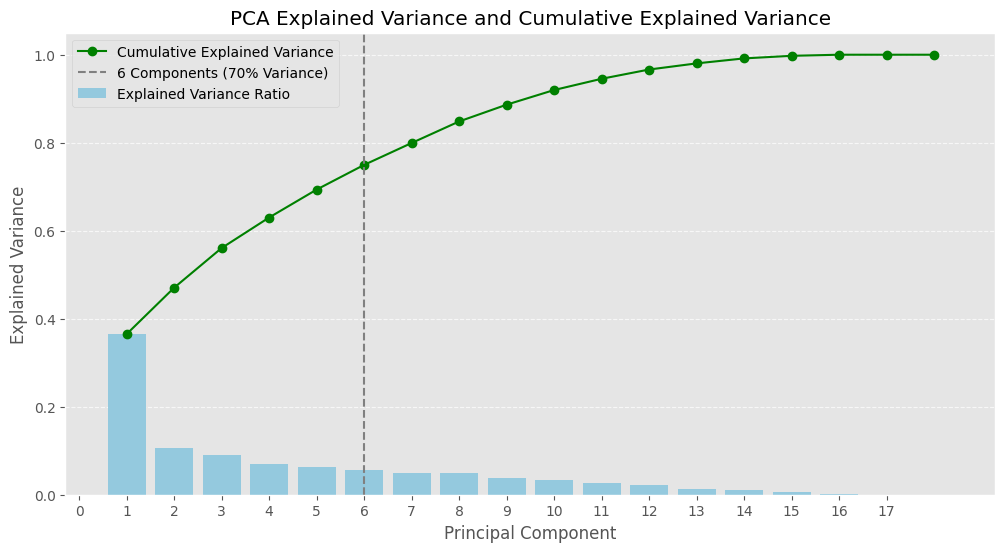

In [12]:
plt.figure(figsize=(12, 6))

# Individual explained variance as bars
sns.barplot(
    x=pca_df["number_component"],
    y=pca_df["explained_variance_ratio"],
    color="skyblue",
    label="Explained Variance Ratio",
)

# Cumulative explained variance as a line plot
plt.plot(
    pca_df["number_component"],
    pca_df["cumulative_explained_variance"],
    color="green",
    marker="o",
    label="Cumulative Explained Variance",
)

# Highlight the number of components that meet a threshold (e.g., 90% cumulative variance)
desired_variance_threshold = 0.70
selected_num_components = (
    np.argmax(pca_df["cumulative_explained_variance"] >= desired_variance_threshold) + 1
)
plt.axvline(
    x=selected_num_components - 1,
    color="grey",
    linestyle="--",
    label=f"{selected_num_components} Components ({desired_variance_threshold*100:.0f}% Variance)",
)

# Plot enhancements
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance and Cumulative Explained Variance")
plt.xticks(ticks=pca_df["number_component"] - 1, labels=pca_df["number_component"])
plt.legend(loc="best")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [13]:
# PCA with components that explain 70% of the variance
pca = PCA(selected_num_components).fit(customers_transactions_scaled)
X_pca = pca.transform(customers_transactions_scaled)
X_pca = pd.DataFrame(X_pca, index=customers_transactions_to_model.index)
np.cumsum(pca.explained_variance_ratio_)

array([0.36486666, 0.47030725, 0.56051595, 0.6299001 , 0.69338625,
       0.74952513])

### 3.3 | Clustering

O K-means será aplicado para clusterizar os dados. O K-means é um algoritmo de clusterização simples que não necessita de muitos ajustes de parâmetros e por isso foi escolhido.

Inicialmente será escolhido o número de clusters, para tal o K-means será aplicado com diferentes número de clustes (10) e o método Elbow será utilizado para selecionar o número de clusters.

In [14]:
inertia = []
silhouette_scores = []
k_values = range(1, 16)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    if len(np.unique(kmeans.labels_)) > 1:
        silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))
    else:
        silhouette_scores.append(np.nan)

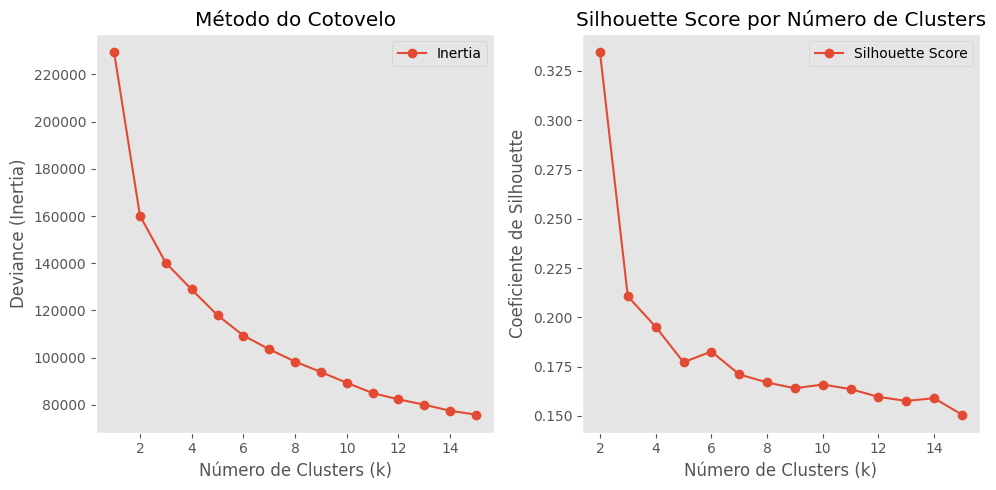

In [15]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker="o", linestyle="-", label="Inertia")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Deviance (Inertia)")
plt.title("Método do Cotovelo")
plt.grid()
plt.legend()

# Plotando o Coeficiente de Silhouette
plt.subplot(1, 2, 2)
plt.plot(
    k_values,
    silhouette_scores,
    marker="o",
    linestyle="-",
    label="Silhouette Score",
)
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Coeficiente de Silhouette")
plt.title("Silhouette Score por Número de Clusters")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

Conforme a metodologia Elbow o número de clusters selecionados é 5, visto que não se observa um "cotovelo" claro no gráfico e, ao complementar a análise com o silhouette score tem-se que o número de clusters acima de 6 tem um score muito baixo.

In [16]:
# Escolha com base no gráfico do método do cotovelo
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

In [17]:
# Save the model as a pickle file
model_pkl_file = "../models/customer_segmentation.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(kmeans, file)

In [18]:
df_x_pca = X_pca.copy()
df_x_pca['cluster'] = cluster_labels
df_x_pca.head()

,0,1,2,3,4,5,cluster
customer_id,,,,,,,
0009655768c64bdeb2e877511632db8f,-0.664886,0.423494,0.563299,-0.652161,0.524172,0.116936,2
00116118485d4dfda04fdbaba9a87b5c,-2.953533,1.307445,-0.203849,0.141802,-0.804216,1.551197,1
0011e0d4e6b944f998e987f904e8c1e5,-1.193327,0.323374,-0.270355,-0.326173,-1.120070,-0.651037,1
0020c2b971eb4e9188eac86d93036a77,1.462826,-1.693597,0.767435,-0.910707,1.030233,0.614573,4
0020ccbbb6d84e358d3414a3ff76cffd,-0.174116,-0.037168,0.686684,0.525994,0.926697,-0.549933,2


Avaliação do modelo

In [19]:
# WSS (Within-cluster sum of squares)
print(f'WSS Value: {kmeans.inertia_}')

# SS (Silhouette Score)
print(f'SS Value: {silhouette_score(X_pca, cluster_labels)}')

WSS Value: 117987.82146017435
SS Value: 0.17723185394748986


In [20]:
df_x_pca = df_x_pca.reset_index()
customers_cluster = customers_transactions_to_model.merge(
    df_x_pca[["customer_id", "cluster"]], on="customer_id", how="inner"
)
customers_cluster.shape

(16994, 20)

# 4 | Análise por cluster

In [21]:
customers_cluster.head(3)

,customer_id,total_offer_completed,total_offer_received,total_offer_viewed,total_transaction,total_social,total_mobile,total_email,total_web,total_bogo,total_discount,total_informational,agv_time_to_view,avg_time_to_complete,credit_card_limit,days_as_customer,avg_amount,min_value,gender,cluster
0,0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,16.0,20.0,20.0,17.0,4.0,11.0,5.0,1.200,0.00,72000.000000,2796.0,15.625000,5.0,1,2
1,00116118485d4dfda04fdbaba9a87b5c,0.0,4.0,4.0,0.0,8.0,8.0,8.0,8.0,8.0,0.0,0.0,2.125,0.00,65404.991568,2427.0,0.000000,5.0,2,1
2,0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,4.0,6.0,14.0,17.0,15.0,6.0,7.0,4.0,0.650,2.25,57000.000000,2533.0,14.971667,6.4,2,1


In [22]:
gender_mapping = {0: "F", 1: "M", 2: "O"}
customers_cluster["gender"] = customers_cluster["gender"].map(gender_mapping).astype(str)
customers_cluster.head(3)

,customer_id,total_offer_completed,total_offer_received,total_offer_viewed,total_transaction,total_social,total_mobile,total_email,total_web,total_bogo,total_discount,total_informational,agv_time_to_view,avg_time_to_complete,credit_card_limit,days_as_customer,avg_amount,min_value,gender,cluster
0,0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,16.0,20.0,20.0,17.0,4.0,11.0,5.0,1.200,0.00,72000.000000,2796.0,15.625000,5.0,M,2
1,00116118485d4dfda04fdbaba9a87b5c,0.0,4.0,4.0,0.0,8.0,8.0,8.0,8.0,8.0,0.0,0.0,2.125,0.00,65404.991568,2427.0,0.000000,5.0,O,1
2,0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,4.0,6.0,14.0,17.0,15.0,6.0,7.0,4.0,0.650,2.25,57000.000000,2533.0,14.971667,6.4,O,1


In [23]:
customers_cluster_analysis = (
    customers_cluster.groupby(by=["cluster"])
    .agg(
        number_of_customers=("customer_id", "count"),
        total_offer_completed=("total_offer_completed", "sum"),
        total_offer_received=("total_offer_received", "sum"),
        total_offer_viewed=("total_offer_viewed", "sum"),
        total_transaction=("total_transaction", "sum"),
        total_social=("total_social", "sum"),
        total_mobile=("total_mobile", "sum"),
        total_email=("total_email", "sum"),
        total_web=("total_web", "sum"),
        total_bogo=("total_bogo", "sum"),
        total_discount=("total_discount", "sum"),
        total_informational=("total_informational", "sum"),
        agv_time_to_view=("agv_time_to_view", "mean"),
        avg_time_to_complete=("avg_time_to_complete", "mean"),
        avg_credit_card_limit=("credit_card_limit", "mean"),
        days_as_customer=("days_as_customer", "mean"),
        avg_amount=("avg_amount", "mean"),
        min_value=("min_value", "mean"),
    )
    .reset_index()
    .sort_values(by="cluster")
)

In [24]:
# Add viewd and completed ratio per cluster
customers_cluster_analysis["viewed_ratio"] = np.round(
    customers_cluster_analysis["total_offer_viewed"]
    / customers_cluster_analysis["total_offer_received"],
    4,
)
customers_cluster_analysis["completed_ratio"] = np.round(
    customers_cluster_analysis["total_offer_completed"]
    / customers_cluster_analysis["total_offer_viewed"],
    4,
)

In [25]:
# Add the type of offer proportinal the number of clusters
customers_cluster_analysis["bogo_per_customer"] = (
    customers_cluster_analysis["total_bogo"]
    / customers_cluster_analysis["number_of_customers"]
)
customers_cluster_analysis["discount_per_customer"] = (
    customers_cluster_analysis["total_discount"]
    / customers_cluster_analysis["number_of_customers"]
)
customers_cluster_analysis["informational_per_customer"] = (
    customers_cluster_analysis["total_informational"]
    / customers_cluster_analysis["number_of_customers"]
)

A partir dos clusters tem-se:

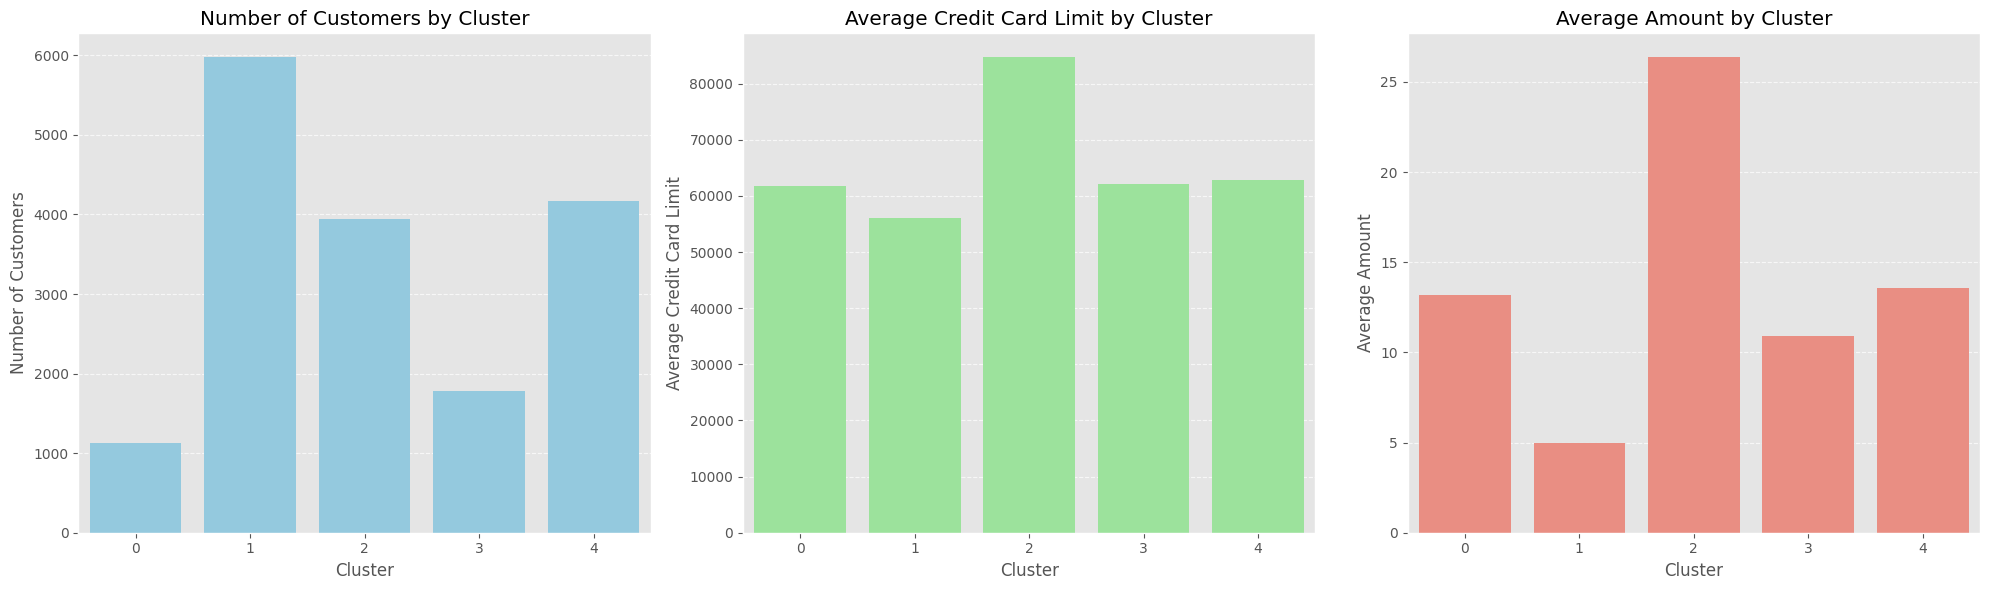

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=False, sharey=False)

# 1. Number of customers by cluster
sns.barplot(
    ax=axes[0],
    data=customers_cluster_analysis,
    x="cluster",
    y="number_of_customers",
    color="skyblue",
)
axes[0].set_title("Number of Customers by Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Number of Customers")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# 2. Average credit card limit by cluster
sns.barplot(
    ax=axes[1],
    data=customers_cluster_analysis,
    x="cluster",
    y="avg_credit_card_limit",
    color="lightgreen",
)
axes[1].set_title("Average Credit Card Limit by Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Average Credit Card Limit")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# 3. Average amount by cluster
sns.barplot(
    ax=axes[2],
    data=customers_cluster_analysis,
    x="cluster",
    y="avg_amount",
    color="salmon",
)
axes[2].set_title("Average Amount by Cluster")
axes[2].set_xlabel("Cluster")
axes[2].set_ylabel("Average Amount")
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

# Ajustar o layout para não sobrepor elementos
plt.tight_layout()
plt.show()

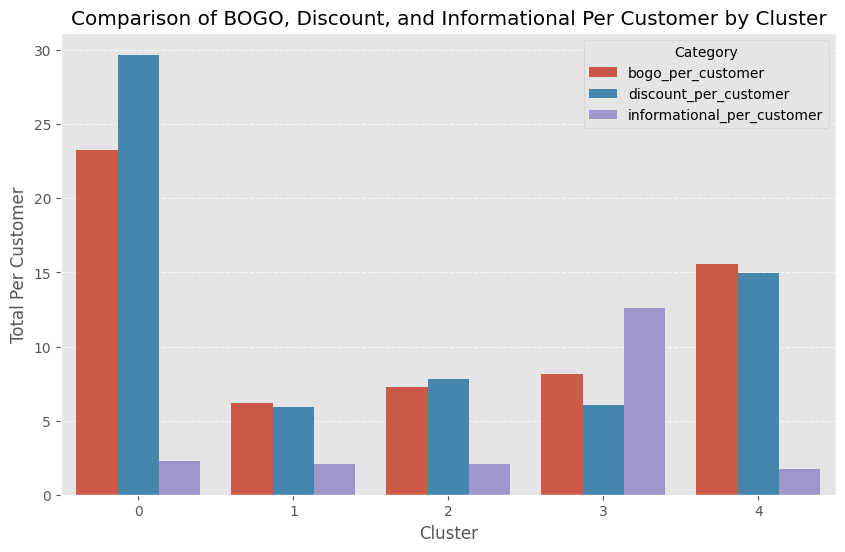

In [27]:
df_melted = customers_cluster_analysis.melt(
    id_vars="cluster",
    value_vars=[
        "bogo_per_customer",
        "discount_per_customer",
        "informational_per_customer",
    ],
    var_name="Category",
    value_name="Total Per Customer",
)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="cluster", y="Total Per Customer", hue="Category")
plt.title("Comparison of BOGO, Discount, and Informational Per Customer by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Per Customer")
plt.legend(title="Category", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

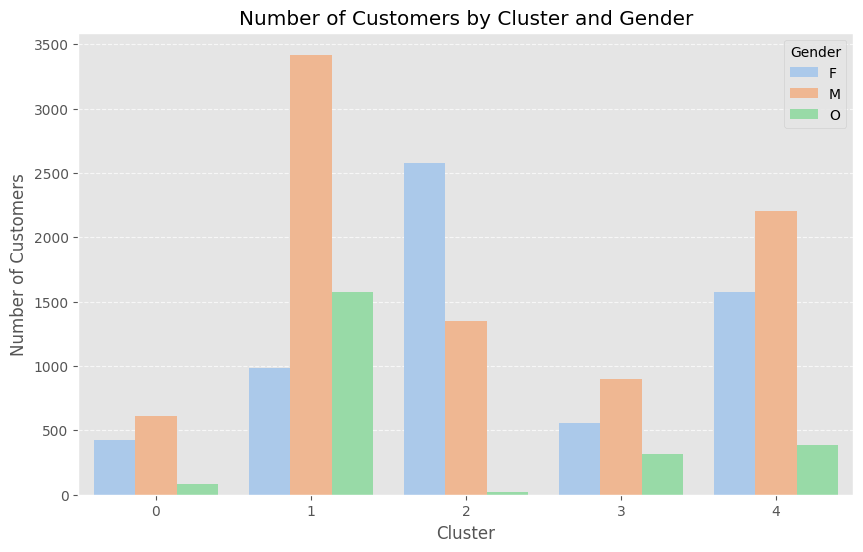

In [28]:
customers_cluster_gender_agg = (
    customers_cluster[["gender", "customer_id", "cluster"]]
    .groupby(by=["cluster", "gender"])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=customers_cluster_gender_agg,
    x="cluster",
    y="count",
    hue="gender",
    palette="pastel",
)
plt.title("Number of Customers by Cluster and Gender")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.legend(title="Gender", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

A partir do modelo tem-se:

- **Cluster 0:**
    - Menor cluster, tem 1123 clientes atribuídos a ele
    - A maior proporção de ofertas recebidas são do tipo de desconto, seguida por BOGO
    - Média de gastos, ```avg_amount``` é de 13.21
    - Clientes que tem uma alta taxa de visualização e finalização

- **Cluster 1:**
    - Média de gastos, ```avg_amount``` é de 4.99
    - A proporção de ofertas recebidas por cliente é similar para o tipo BOGO e desconto
    - Recebem mais ofertas pelo canal de email 
    - Tem uma baixa taxa de finalização (0.23)
    - Majoritariamente do gênero masculino

- **Cluster 2:**
    - Maior cluster, tem 3945 clientes atribuídos a ele
    - Tem a menor média de gastos, ```avg_amount``` é de 26.37
    - Tem uma alta taxa de finalização
    - Composto majoritariamente pelo gênero feminino

- **Cluster 3:**
    - Tem uma média de gastos, ```avg_amount``` é de 10.92
    - Também tem uma alta taxa de visualização (0.81), mas baixa de finalização finalização (0.25)
    - Tem a menor proporção de ofertas por cliente

- **Cluster 4:**
    - Tem a menor média de gastos, ```avg_amount``` é de 13.55
    - Oferta são mais recebidas pelo email
    - Tem uma taxa de finalização de 0.77

# 5 | Próximos passos:

A partir do primeiro modelo testado, pode-se iterar ou testar outros modelos para fazer a segmentação dos clientes (aplicar algoritmos hierárquicos, DBSCAN, GMM, etc). Além disto pode-se buscar balancear o número de clientes em cada cluster também. 